In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

In [17]:
station_id = '23025122'
meses = range(1,13)
data_names = ['tempsolocm40cm']

Funções de fitness das operações

In [3]:
# Funções de Fitness
def calc_smaller(a: float, b: float):
	return b - a
def calc_greater(a: float, b: float):
	return a - b
def calc_smaller_or_equal(a: float, b: float):
	return b - a + 1
def calc_greater_or_equal(a: float, b: float):
	return a - b + 1
def calc_equal(a: float, b: float):
	return -abs(a - b)
def calc_and(a: float, b: float):
	return min(a, b)
def calc_or(a: float, b: float):
	return max(a, b)
def calc_not(a: float):
	return -a

Função que roda o programa em java

In [4]:
def run_stl(stl_input, grammar='grammar_idr.bnf', seed=1337, tournament_size=5, n_iterations=50):
  stl_cmd = 'java -Dfile.encoding=UTF-8 -classpath "./target\\classes;.\\libs\\JGEA.jar;.\\libs\\moonlight.jar;.\\libs\\jblas-1.2.4.jar" it.units.malelab.learningstl.Main seed={} grammar=grammars/{} local_search=false input={} tournament_size={} number_iterations={}'.format(seed, grammar, stl_input, tournament_size, n_iterations)
  return os.system(stl_cmd)

In [5]:
def plot(vals, detected_anomalies=[], continuous_anomalies=[], margins=None, title='', save=False, img_name=None, show=True, sec_plots=[]):
	fig, ax = plt.subplots(figsize=(20, 4), dpi=720)
	ax.set_title(title)
	sns.lineplot(data=vals)
	for subplot in sec_plots:
		sns.lineplot(data=subplot)
	for i in detected_anomalies:
		plt.scatter(i, vals[i], s=800, marker="x", color="r", alpha=0.6)
	anom_dev = (max(vals) - min(vals))
	for i in continuous_anomalies:
		anom_top_margins = []
		anom_bottom_margins = []
		for point in range(i[0], i[1]):
			anom_top_margins.append(vals[point]+anom_dev)
			anom_bottom_margins.append(vals[point]-anom_dev)
		plt.fill_between(range(i[0], i[1]), anom_top_margins, anom_bottom_margins, alpha = 0.7, color="r", interpolate=True)
	j = 0
	if margins:
		for margin in margins:
			plt.fill_between(range(len(vals)), margin[0], margin[1], alpha = 0.1, color="b")
	fig.tight_layout()
	if save:
		fig.savefig(img_name if img_name is not None else title, bbox_inches='tight')
	if show:	
 		plt.show()
	else:
		plt.close(fig)
	

In [6]:
def unnormalize(val, min_val, max_val):
	return (val * (max_val - min_val)) + min_val
def unnormalize_string(min_maxes):
	def f(match_group):
		if match_group[1][0] == 'H':
			min_val = 0
			max_val = 1
		elif match_group[1] == 'hour':
			min_val = 0
			max_val = 23
		else:
			min_val = min_maxes[match_group[1]][0]
			max_val = min_maxes[match_group[1]][1]

		return '{} {} {}'.format(match_group[1], match_group[2], unnormalize(float(match_group[3]), min_val, max_val))
	return f

Função que parseia e avalia uma regra

In [7]:
def parse_rule(rule: str):
	regex_search = re.search(r'AND|NOT|OR', rule)
	if not regex_search:
		# É operador simples
		var, comp, val = re.search(r'([a-zA-Z0-9]*) ([<>=]*) ([0-9\.]*)', rule).groups()
		val = float(val)
		def comp_func(line):
			if comp == '>':
				# if not line[var] > val:
				# 	print('{} ({}) é <= {}'.format(var, line[var], val))
				return calc_greater(line[var], val)
			elif comp == '<':
				# if not line[var] < val:
				# 	print('{} ({}) é >= {}'.format(var, line[var], val))
				return calc_smaller(line[var], val)
			elif comp == '<=':
				# if not line[var] < val:
				# 	print('{} ({}) é >= {}'.format(var, line[var], val))
				return calc_smaller_or_equal(line[var], val)
			elif comp == '>=':
				# if not line[var] < val:
				# 	print('{} ({}) é >= {}'.format(var, line[var], val))
				return calc_greater_or_equal(line[var], val)
			else:
				# if not line[var] == val:
				# 	print('{} ({}) é != {}'.format(var, line[var], val))
				return calc_equal(line[var], val)
		return comp_func
	sub_rule = rule[regex_search.span()[1]+1:-1]
	if regex_search[0] == 'AND':
		count = 0
		sub_rule_1 = 'nada'
		sub_rule_2 = 'nada'
		for i, l in enumerate(sub_rule):
			if l == '[':
				count+=1
			if l == ']':
				count-=1
			if l == ';' and count == 0:
				sub_rule_1 = sub_rule[:i]
				sub_rule_2 = sub_rule[i+1:]
				sub_rule_func_1 = parse_rule(sub_rule_1)
				sub_rule_func_2 = parse_rule(sub_rule_2)
				def and_function(line):
					res_func_1 = sub_rule_func_1(line)
					res_func_2 = sub_rule_func_2(line)
					# if not (res_func_1 and res_func_2):
					# 	print('{} é falso porque'.format(sub_rule))
					# if not res_func_1:
					# 	print('{} é falso'.format(sub_rule_1))
					# if not res_func_2:
					# 	print('{} é falso'.format(sub_rule_2))
					return calc_and(res_func_1, res_func_2)
				return and_function
	if regex_search[0] == 'OR':
		count = 0
		sub_rule_1 = 'nada'
		sub_rule_2 = 'nada'
		for i, l in enumerate(sub_rule):
			if l == '[':
				count+=1
			if l == ']':
				count-=1
			if l == ';' and count == 0:
				sub_rule_1 = sub_rule[:i]
				sub_rule_2 = sub_rule[i+1:]
				sub_rule_func_1 = parse_rule(sub_rule_1)
				sub_rule_func_2 = parse_rule(sub_rule_2)
				def or_function(line):
					res_func_1 = sub_rule_func_1(line)
					res_func_2 = sub_rule_func_2(line)
					# if not (res_func_1 and res_func_2):
					# 	print('{} é falso porque'.format(sub_rule))
					# if not res_func_1:
					# 	print('{} é falso'.format(sub_rule_1))
					# if not res_func_2:
					# 	print('{} é falso'.format(sub_rule_2))
					return calc_or(res_func_1, res_func_2)
				return or_function
	if regex_search[0] == 'NOT':
		sub_rule_func = parse_rule(sub_rule)
		def not_funcion(line):
			res_func = sub_rule_func(line)
			# if res_func:
			# 	print('{} é verdadeiro'.format(sub_rule))
			return -res_func
		return not_funcion

In [8]:
# Função que cria as ranges
def sep_anomalies(anomalies):
	anom_start = -1
	continuous_anomalies = []
	for i, anomaly in enumerate(anomalies):
		# Se o próximo for anomalia
		if i < (len(anomalies) - 1) and anomalies[i+1] == anomaly+1:
			# E o anterior não for ou for o primeiro da lista
			if anomalies[i-1] != anomaly-1 or i == 0:
				# É começo de uma contínua
				anom_start = anomaly
		# Se o anterior é anomalia e o próximo não for ou for o fim da lista, é fim de contínuo
		elif i > 0 and anomalies[i-1] == anomaly-1:
			continuous_anomalies.append((anom_start, anomaly))
			anom_start = -1
		# Se o próximo e o anterior não forem anomalia, é isolado
		else:
			continuous_anomalies.append((anomaly, anomaly))
	return continuous_anomalies

In [178]:
# parser_mes1 = parse_rule(regra_mes1)
# parser_mes2 = parse_rule(regra_mes2)

In [179]:
# sum_rob = 0
# for i, r in mes1.iterrows():
# 	rob = parser_mes1(r)
# 	sum_rob += rob
# 	if rob >= 0:
# 		print(i)
# print(sum_rob)

Gerando regras e limpando saída

In [21]:
img_name = 'tempsolocm40cm.{}.dia_id.season_0'.format(station_id)
series_name = 'tempsolocm40cm.{}.dia_id.season_0.csv'.format(station_id)
grammar = 'grammar_idr_sem_hora.bnf'
series_file = './data/seasons/tempsolocm40cm/{}'.format(series_name)
output_file = './output/{}'.format(series_name)

In [37]:
d = pd.read_csv(series_file)
for year in d.groupby(['year']):
  if year[0] == 2020:
    year[1].to_csv('./verão.2020.csv', index=False)

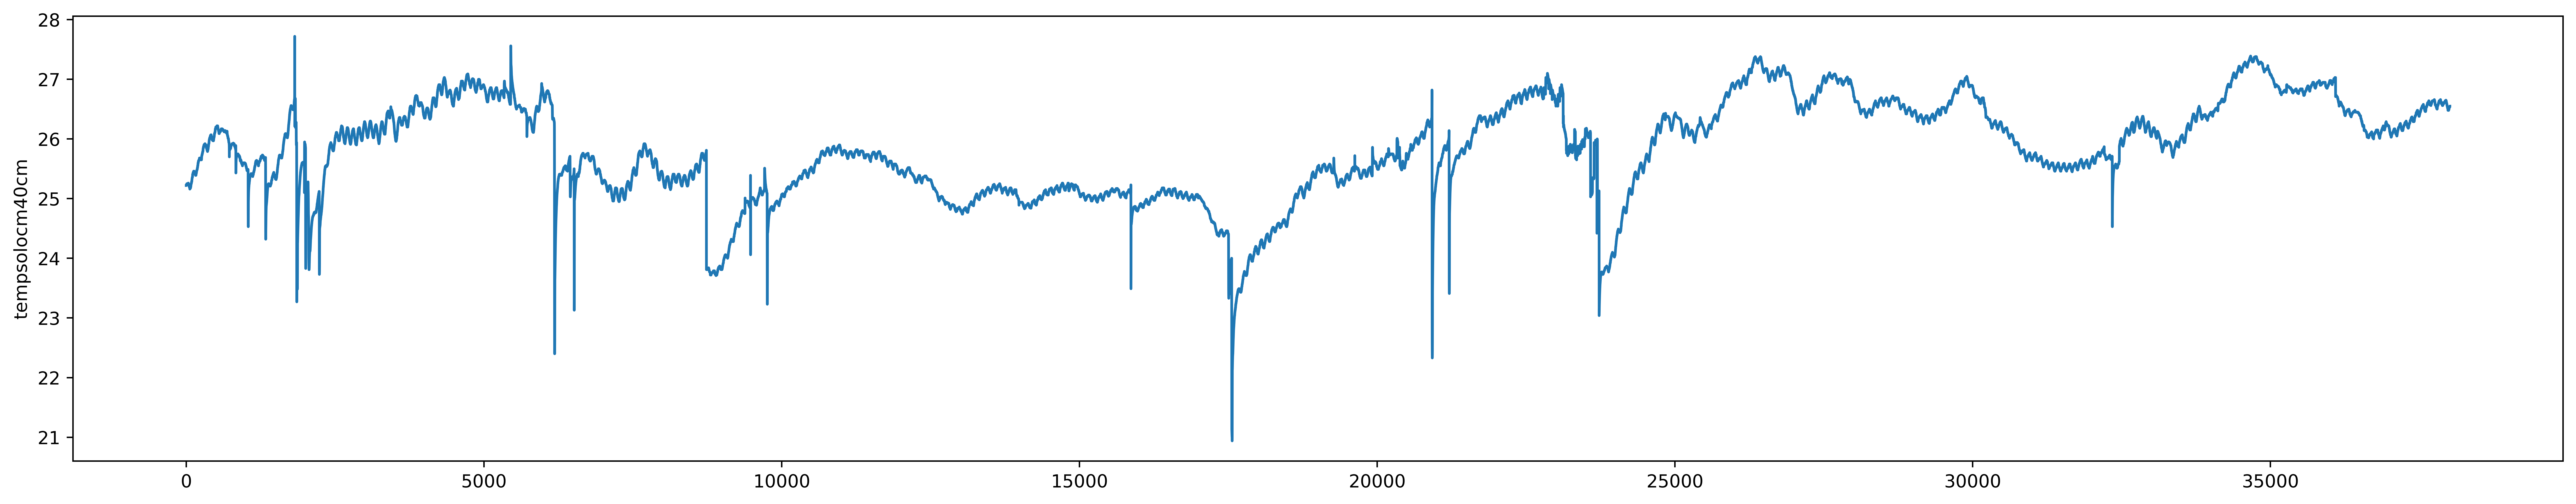

In [25]:
plot(pd.read_csv(series_file)['tempsolocm40cm'], save=True, img_name='tempsolocm40cm.verão.jpg')

In [50]:
stl_run = run_stl('./verão.2020.sem_tempo.csv', seed=123456, n_iterations=100, tournament_size=8, grammar=grammar) 
print(stl_run)
if stl_run != 0:
	print('./verão.2020.sem_tempo.csv', grammar)
else:
	series = pd.read_csv('./verão.2020.sem_tempo.csv')

	# Limpando headers adicionais
	with open('./output/verão.2020.sem_tempo.csv', 'r') as f:
		lines = f.readlines()
	with open('./output/verão.2020.sem_tempo.csv', 'w') as f:
		for i, line in enumerate(lines):
			if i == 0 or not line.startswith('iterations,births,fitness.evaluations'):
					f.write(line)

	output = pd.read_csv('./output/verão.2020.sem_tempo.csv')

	# Desnormalizando a saída
	min_max = {
		# 'month': (min(series['month']), max(series['month'])),
	}

	for feature in data_names:
		min_max[feature] = (min(series[feature]), max(series[feature]))

	output['serialized'] = [re.sub(r'([a-zA-Z0-9]*) ([<>=]*) ([0-9\.]*)', unnormalize_string(min_max), rule) for rule in output['serialized']]
	output.to_csv('./output/verão.2020.sem_tempo.csv', index=0)

	# regras = output['serialized'].to_list()
	# avaliacoes = output['best.fitness.value'].to_list()
	# # Tirando regras que não usam a temperatura
	# # regras = [regra for regra in regras if regra.find(data_name) >= 0]
	# # eval_regras = []
	# for regra, score in zip(regras, avaliacoes):
	# 	function = parse_rule(regra)
	# 	id_linhas = []
	# 	for i, serie in series.iterrows():
	# 		if score < 0:
	# 			id_linhas.append(i)
		
	# 	if regra.find(data_name) >= 0:
	# 		cont = sep_anomalies(id_linhas)
	# 		plot(series[data_name], continuous_anomalies=cont, title='{}, {}'.format(regra, score), save=True, show=False, img_name='./output/{}_{}_{}.jpg'.format(img_name, regra, score))

0


In [ ]:
OR[
  AND[
    NOT[tempsolocm40cm > 26.3711];
    OR[tempsolocm40cm > 26.33975;tempsolocm40cm < 26.09465]
	];
  OR[
    AND[tempsolocm40cm < 26.2514;tempsolocm40cm > 26.1317];
    AND[tempsolocm40cm > 26.4509;tempsolocm40cm < 26.69885]
	]
]

In [ ]:
OR[
  AND[
    OR[tempsolocm40cm > 26.1374;tempsolocm40cm < 26.1089];
    AND[tempsolocm40cm < 26.2514;tempsolocm40cm > 26.08895]
	];
  AND[
    OR[tempsolocm40cm > 26.69885;tempsolocm40cm < 26.4509];
		tempsolocm40cm > 26.34545
	]
]

In [ ]:
OR[
  AND[
    AND[tempsolocm40cm < 26.1374;tempsolocm40cm > 26.10605];
    tempsolocm40cm > 26.07755
	];
  AND[
    OR[tempsolocm40cm > 26.69885;tempsolocm40cm < 26.35115]
    ;tempsolocm40cm > 26.240000000000002
	]
]

In [46]:
pd.read_csv('verão.2020.csv').drop(['month', 'hour', 'year', 'season'], axis=1).to_csv('verão.2020.sem_tempo.csv', index=False)

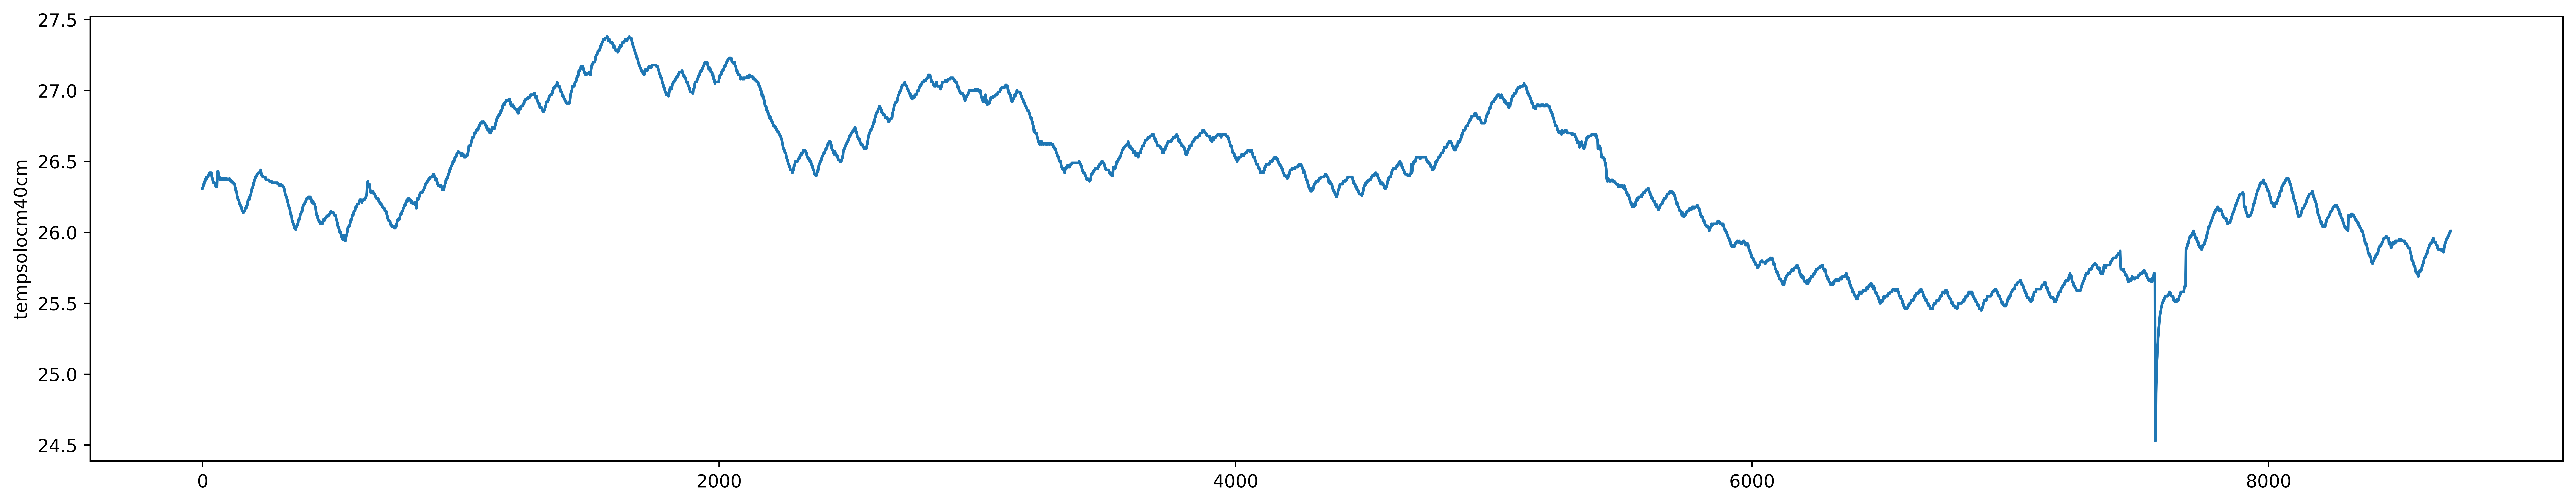

In [41]:
plot(pd.read_csv('verão.2020.csv')['tempsolocm40cm'], save=True, )

In [ ]:
AND[
  OR[tempsolocm40cm > 26.11992;tempsolocm40cm < 25.91652];
  AND[
    tempsolocm40cm > 25.2453;
    OR[tempsolocm40cm < 25.62498;tempsolocm40cm > 25.7538]
	]
]

{'tempsolocm2cm': 0.0}
{'tempsolocm2cm': 0.0}
{'tempsolocm2cm': 0.0}
{'tempsolocm2cm': 0.0}
{'tempsolocm2cm': 0.01}
{'tempsolocm2cm': 0.01}
{'tempsolocm2cm': 0.01}
{'tempsolocm2cm': 0.01}
{'tempsolocm2cm': 0.02}
{'tempsolocm2cm': 0.02}
{'tempsolocm2cm': 0.02}
{'tempsolocm2cm': 0.02}
{'tempsolocm2cm': 0.03}
{'tempsolocm2cm': 0.03}
{'tempsolocm2cm': 0.03}
{'tempsolocm2cm': 0.03}
{'tempsolocm2cm': 0.04}
{'tempsolocm2cm': 0.04}
{'tempsolocm2cm': 0.04}
{'tempsolocm2cm': 0.04}
{'tempsolocm2cm': 0.05}
{'tempsolocm2cm': 0.05}
{'tempsolocm2cm': 0.05}
{'tempsolocm2cm': 0.05}
{'tempsolocm2cm': 0.06}
{'tempsolocm2cm': 0.06}
{'tempsolocm2cm': 0.06}
{'tempsolocm2cm': 0.06}
{'tempsolocm2cm': 0.07}
{'tempsolocm2cm': 0.07}
{'tempsolocm2cm': 0.07}
{'tempsolocm2cm': 0.07}
{'tempsolocm2cm': 0.08}
{'tempsolocm2cm': 0.08}
{'tempsolocm2cm': 0.08}
{'tempsolocm2cm': 0.08}
{'tempsolocm2cm': 0.09}
{'tempsolocm2cm': 0.09}
{'tempsolocm2cm': 0.09}
{'tempsolocm2cm': 0.09}
{'tempsolocm2cm': 0.1}
{'tempsolocm2cm': 0.1

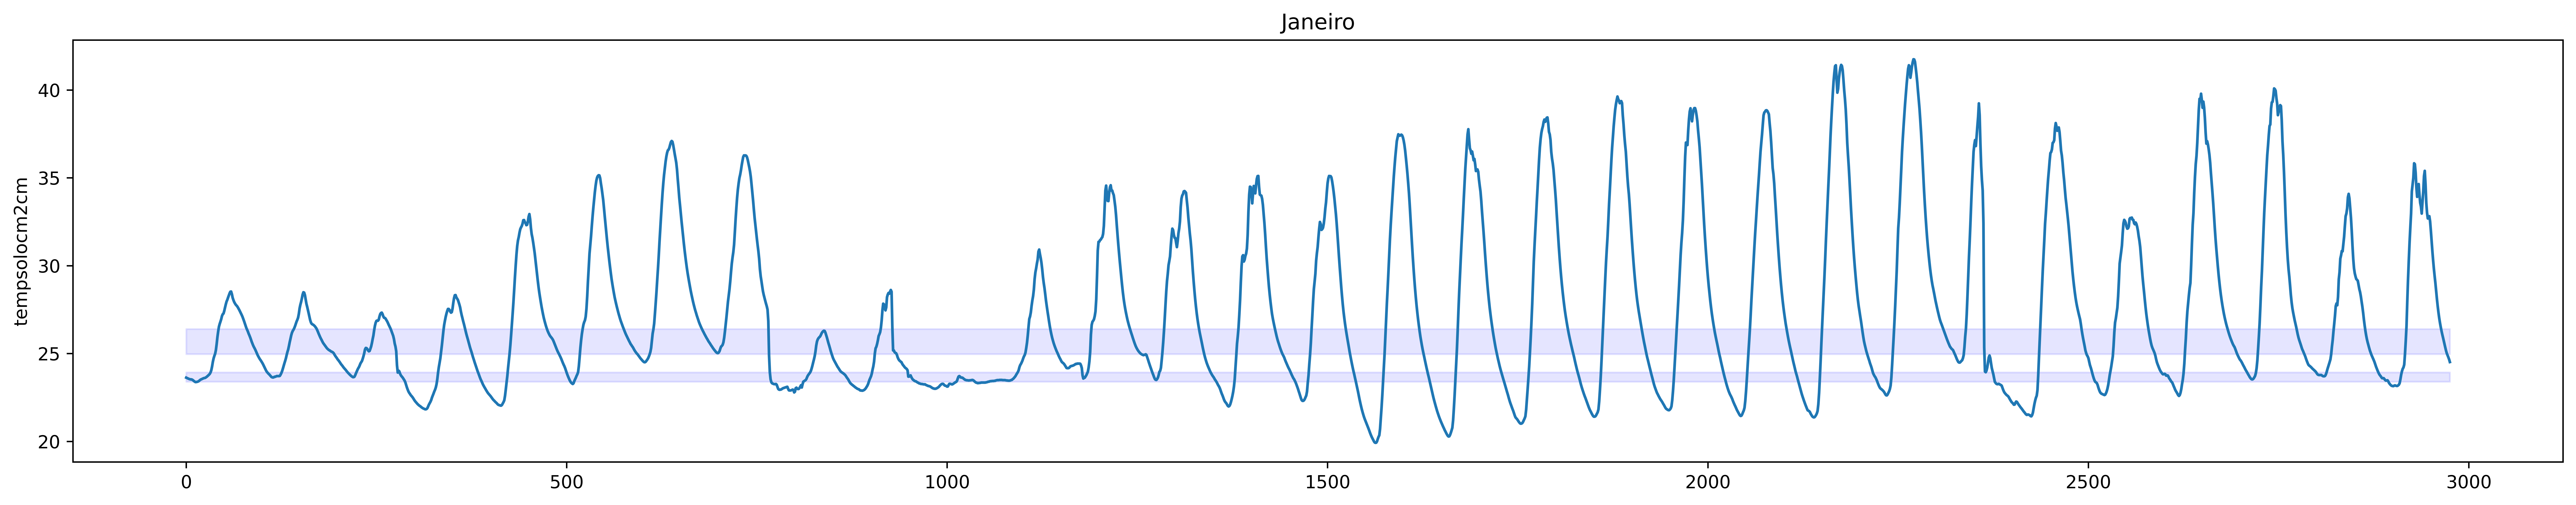

In [204]:
# Lendo melhor regra e criando ranges onde a regra se aplica
regra = pd.read_csv('./output/tempsolocm2cm.23025122.dia_id.mes_1.csv')['serialized'].to_list()[-1]
f_rule = parse_rule(regra)
prev_val = 0
aplies = []
range_tuple = tuple()
for val in np.arange(0, 50, 0.01):
	new_val = f_rule({data_name: val})
	if val == 0 and new_val >= 0:
		range_tuple = (0,)
		prev_val = new_val
		continue
	if prev_val * new_val < 0:
		if new_val < 0:
			range_tuple += (val - 0.01,)
			aplies.append(range_tuple)
		else:
			range_tuple = (val,)
	prev_val = new_val
 
stl_input = pd.read_csv('./data/meses/tempsolocm2cm/tempsolocm2cm.23025122.dia_id.mes_1.csv')
# Separando por dias
meses_jan = [mes[1]['tempsolocm2cm'] for mes in stl_input.groupby(['year'])]
plot(meses_jan[0], margins=aplies, title='Janeiro')

Regra tempsolocm2cm

AND[
  OR[
    NOT[tempsolocm2cm < 24.96];
    tempsolocm2cm < 23.93
	];
  AND[tempsolocm2cm < 26.40;tempsolocm2cm > 23.39]
]

Regra prec e tempsolcm40cm

AND[
	OR[
		OR[prec > 16.6152;prec > 0.6552];
		AND[prec < 0.6048;prec > 0.0]
	];
	tempsolocm40cm < 26.57732
]

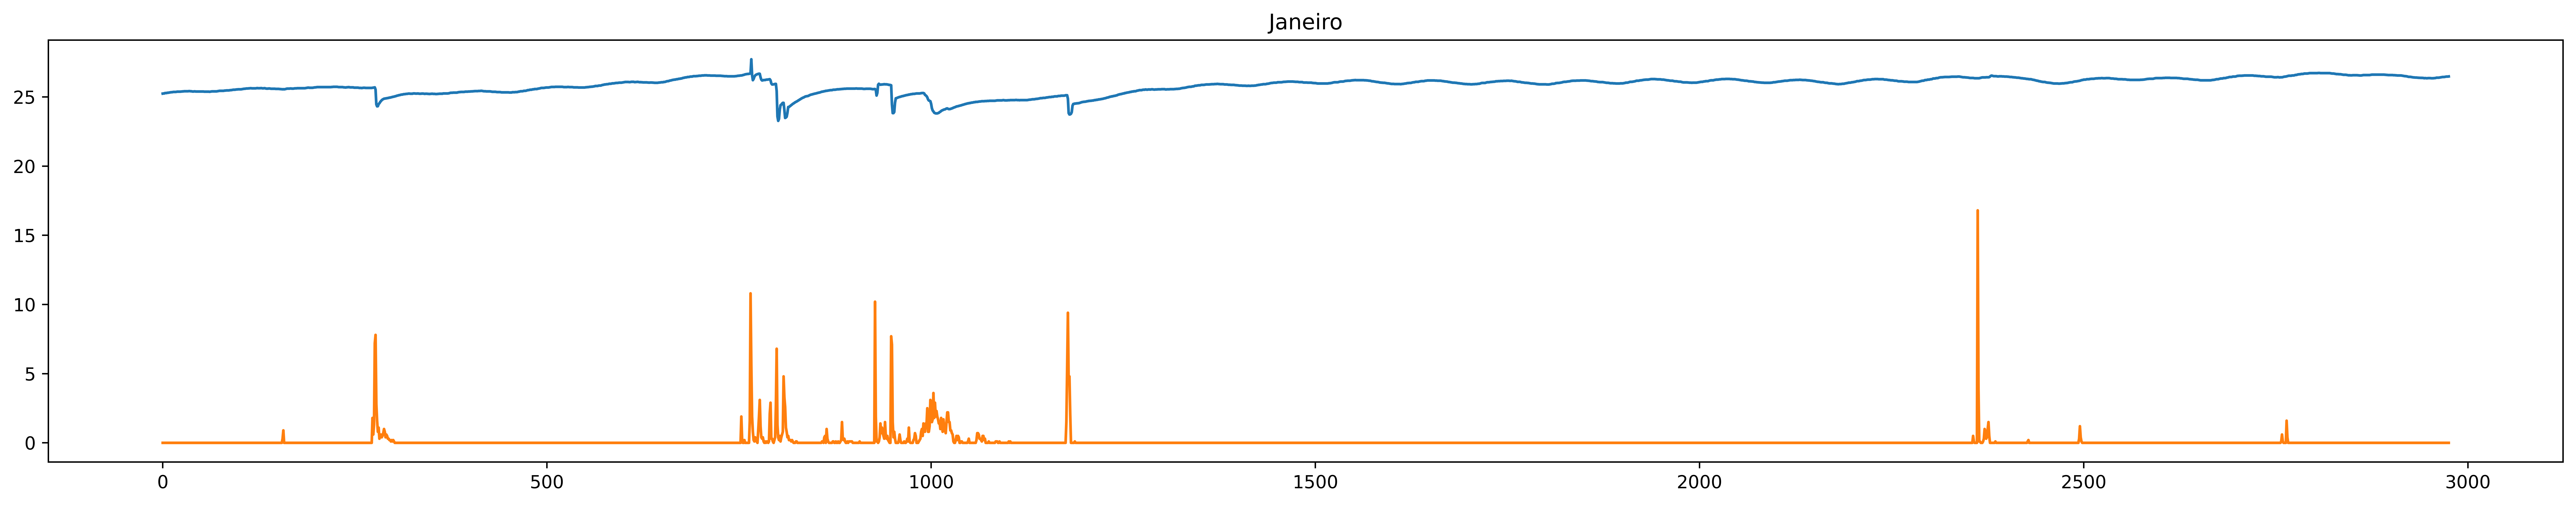

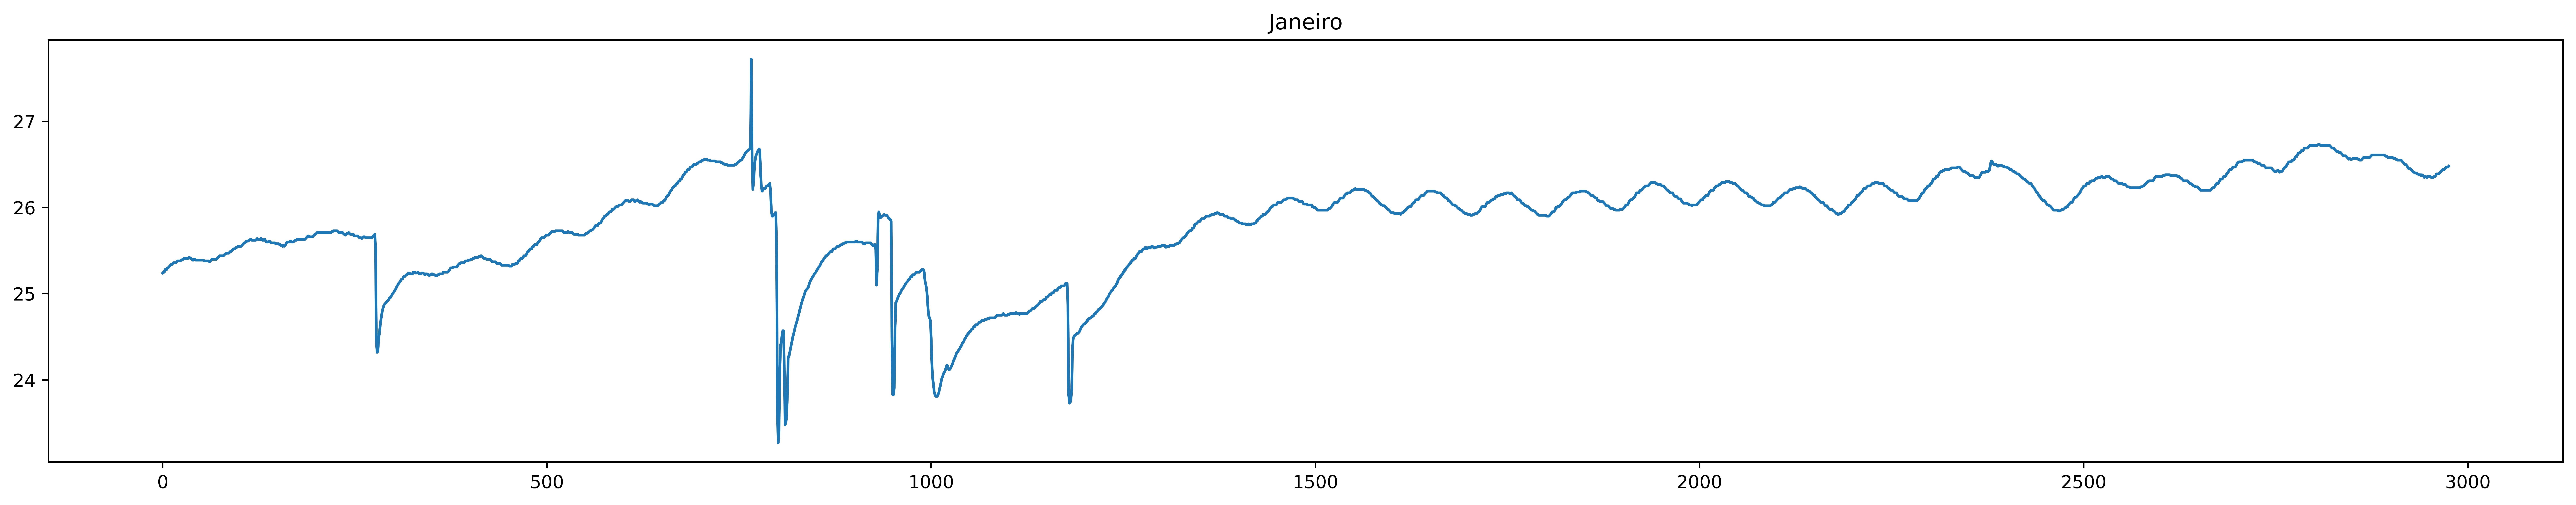

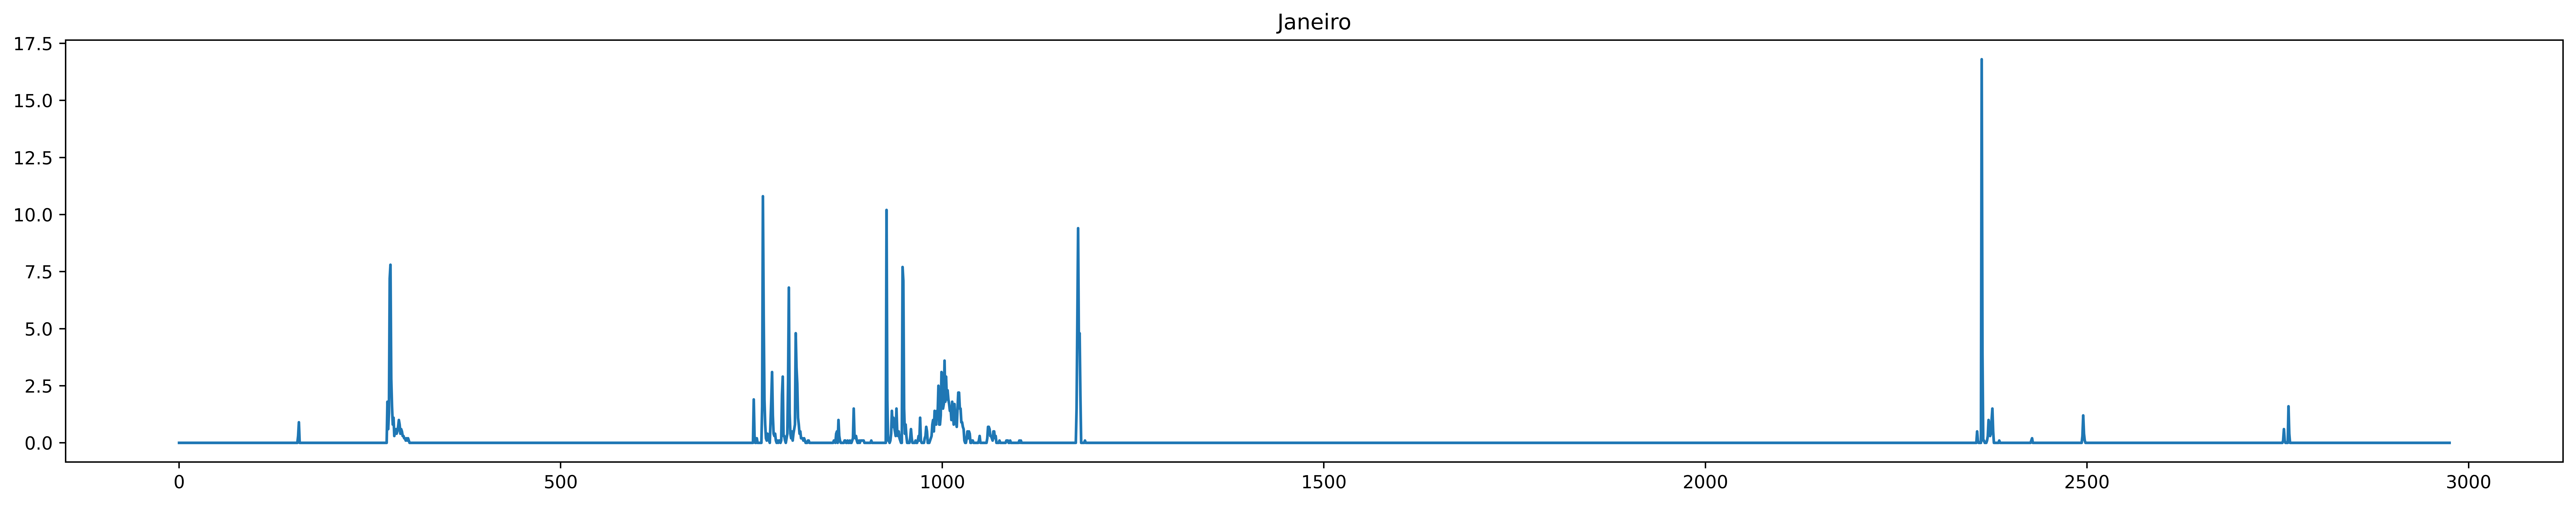

In [198]:
stl_input = pd.read_csv(series_file)
meses_jan = [{'tempsolocm40cm': mes[1]['tempsolocm40cm'], 'prec': mes[1]['prec']} for mes in stl_input.groupby(['year'])]
plot(meses_jan[0]['tempsolocm40cm'].to_list(), sec_plots=[meses_jan[0]['prec'].to_list()], title='Janeiro')

plot(meses_jan[0]['tempsolocm40cm'].to_list(), title='Janeiro')
plot(meses_jan[0]['prec'].to_list(), title='Janeiro')

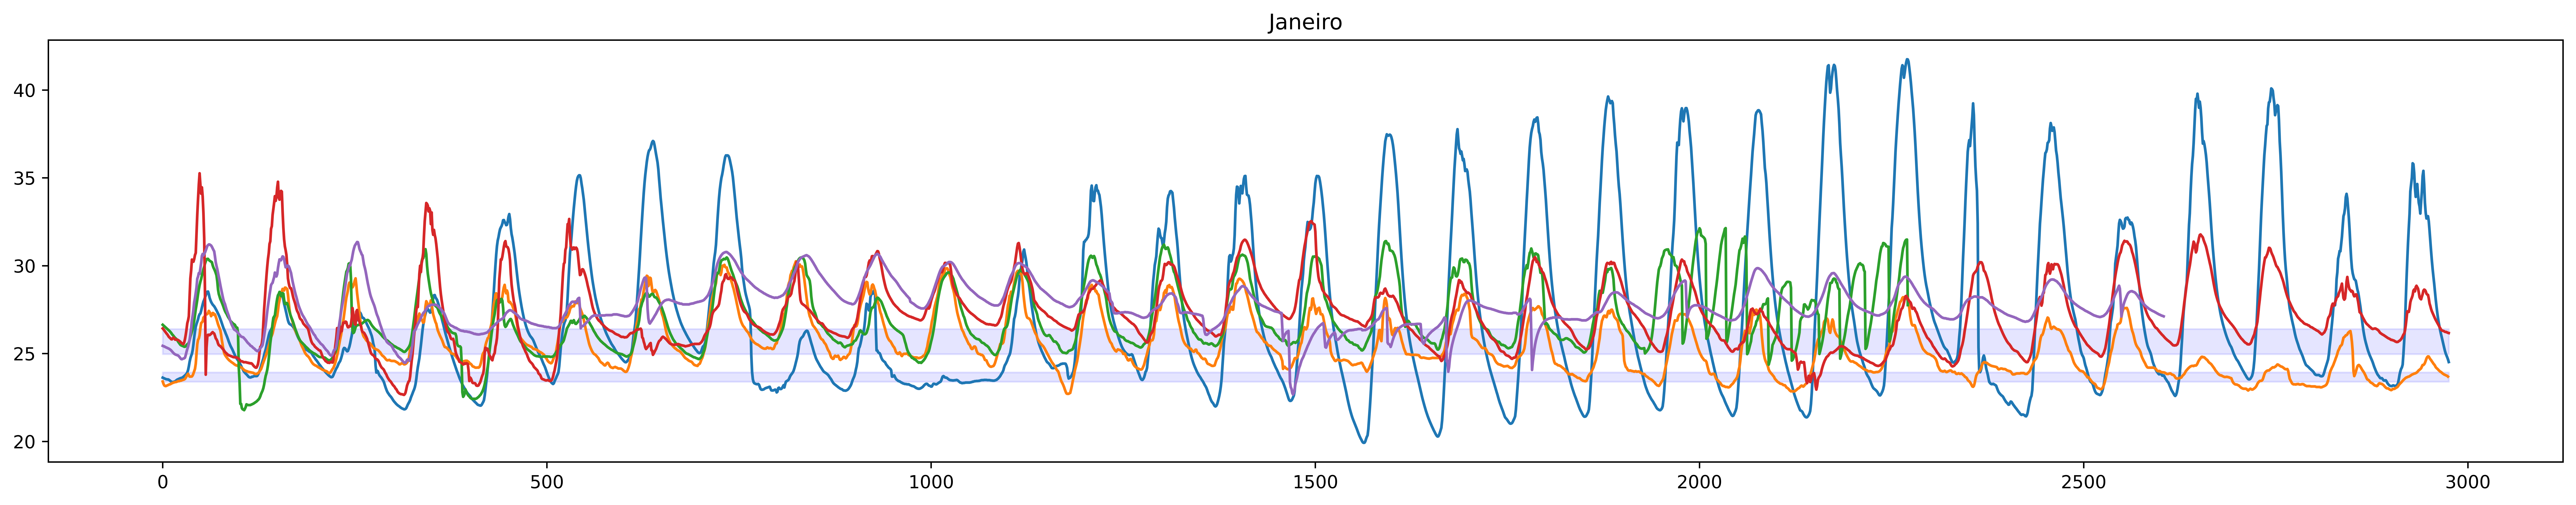

In [205]:
plot(meses_jan[0].to_list(), sec_plots=[m.to_list() for m in meses_jan[1:]], margins=aplies, title='Janeiro')

In [ ]:
img_name = 'prec.tempsolocm40cm.{}.dia_id.mes_1'.format(station_id, mes)
series_name = 'prec.tempsolocm40cm.{}.dia_id.mes_1.csv'.format(station_id, mes)
grammar = 'grammar_idr.bnf'
series_file = './data/meses/{}'.format(series_name)
output_file = './output/{}'.format(series_name)
best_regras = pd.read_csv(output_file)
series = pd.read_csv(series_file)

# Tirando regras que não usam a temperatura
# regras = [regra for regra in regras if regra.find(data_name) >= 0]
# eval_regras = []
regra = best_regras.iloc[-1]
function = parse_rule(regra['serialized'])
id_linhas = []
for i, serie in series.iterrows():
	if function(serie) < 0:
		id_linhas.append(i)
cont = sep_anomalies(id_linhas)
plot(series[data_name], continuous_anomalies=cont, title='{}, {}'.format(regra['serialized'], regra['best.fitness.value']), save=True, show=True, img_name='./output/imagens/{}_{}.jpg'.format(img_name, regra['best.fitness.value']))

In [ ]:
for mes in meses:
	for esparso in [False, True]:
		if esparso:
			img_name = '{}.{}.dia_id.mes_{}.esparso'.format(data_name, station_id, mes)
			series_name = '{}.{}.dia_id.mes_{}.esparso.csv'.format(data_name, station_id, mes)
			grammar = 'grammar_idr_esparso.bnf'
			series_file = './data/meses/{}'.format(series_name)
			output_file = './output/{}'.format(series_name)
		else:
			img_name = '{}.{}.dia_id.mes_{}'.format(data_name, station_id, mes)
			series_name = '{}.{}.dia_id.mes_{}.csv'.format(data_name, station_id, mes)
			grammar = 'grammar_idr.bnf'
			series_file = './data/meses/{}'.format(series_name)
			output_file = './output/{}'.format(series_name)
		best_regras = pd.read_csv(output_file)
		series = pd.read_csv(series_file)
	
		# Tirando regras que não usam a temperatura
		# regras = [regra for regra in regras if regra.find(data_name) >= 0]
		# eval_regras = []
		regra = best_regras.iloc[-1]
		function = parse_rule(regra['serialized'])
		id_linhas = []
		for i, serie in series.iterrows():
			if function(serie) < 0:
				id_linhas.append(i)
		cont = sep_anomalies(id_linhas)
		plot(series[data_name], continuous_anomalies=cont, title='{}, {}'.format(regra['serialized'], regra['best.fitness.value']), save=True, show=False, img_name='./output/imagens/{}_{}.jpg'.format(img_name, regra['best.fitness.value']))

In [ ]:
pd.read_csv('./data/meses/tempsolocm2cm.23025122.dia_id.mes_1.csv').head()

In [ ]:
plot(pd.read_csv('./data/meses/tempsolocm2cm.23025122.dia_id.mes_1.csv')['tempsolocm2cm'], save=True, img_name='img.jpg')